In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem, draw_circles_ctype

import matplotlib.pyplot as plt

from tqdm import tqdm, trange

# Cell State

In [3]:
# NOTE: no need to have chemical gradients
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    hidden_state:       jax.Array

In [4]:
N_DIM = 2
N_CHEM = 2
N_HIDDEN = 16
N_CTYPES = 2

N = 120
N_ADD = int(N-2)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.vstack([np.asarray([[-.25, 0],[.25, 0.]]), np.zeros(shape=(N-2,N_DIM))]),
    celltype=       np.vstack([np.eye(N_CTYPES), np.zeros(shape=(N-2,N_CTYPES))]),
    radius=         np.zeros(shape=(N,1)).at[:2].set(.5),
    division=       np.zeros(shape=(N,1)).at[:2].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[:2].set(1.),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Reinforce Training

## ANN Model

In [7]:
key, *init_keys = jax.random.split(key, 4)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.),
        

        jxm.cell.mlp.CellStateMLP(istate,
                                input_fields=['chemical', 'division', 'radius'],
                                output_fields=['hidden_state'],
                                memory=.8,
                                key=init_keys[0],
        ),


        jxm.cell.mlp.CellStateMLP(istate,
                                input_fields=['hidden_state'],
                                output_fields=['secretion_rate'],
                                transform_output={'secretion_rate': lambda s,x: jax.nn.sigmoid(x/10.)},
                                key=init_keys[1],
        ),


        jxm.cell.SecretionMaskByCellType(istate, np.eye(N_CTYPES).tolist()),

        jxm.cell.mlp.CellStateMLP(istate,
                                input_fields=['hidden_state'],
                                output_fields=['division'],
                                transform_output={'division': lambda s,x: jax.nn.softplus(x)},
                                key=init_keys[2],
        ),

        
    ])

In [82]:
EPOCHS = 50
N_EPISODES = 8
N_VAL_EPISODES = 32

COST_FN = jxm.opt.cost_functions.CellTypeImbalance(metric='number')

GAMMA = .9
LAMBDA = 0.

LOSS = jxm.opt.losses.ReinforceLoss(COST_FN,
                                    n_sim_steps=N_ADD,
                                    n_episodes=N_EPISODES,
                                    n_val_episodes=N_VAL_EPISODES,
                                    gamma=GAMMA,
                                    lambda_l1=LAMBDA,
                                    )


opt_results = jxm.opt.train(model, istate, LOSS, key=key, epochs=EPOCHS)

Loss: 5.06250: 100%|████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


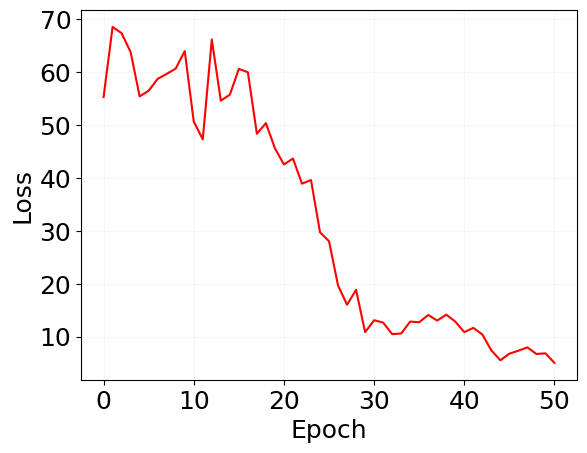

In [83]:
plt.plot(opt_results.loss_aux, 'r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.1);

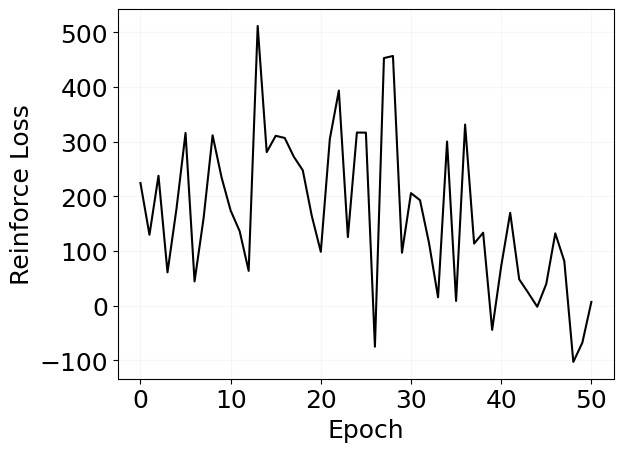

In [84]:
plt.plot(opt_results.loss, 'k')

plt.xlabel('Epoch')
plt.ylabel('Reinforce Loss')

plt.grid(alpha=.1);

In [85]:
def _final_cost_distribution(model, istate, subkeys, n_sim_steps):

    vsim = jax.vmap(jxm.simulate, (None, None, 0, None))

    fstate, _ = vsim(model, istate, subkeys, n_sim_steps)

    cost = fstate.celltype.sum(-2) @ np.asarray([1.,-1.])

    cost = np.abs(cost)

    return cost.tolist()

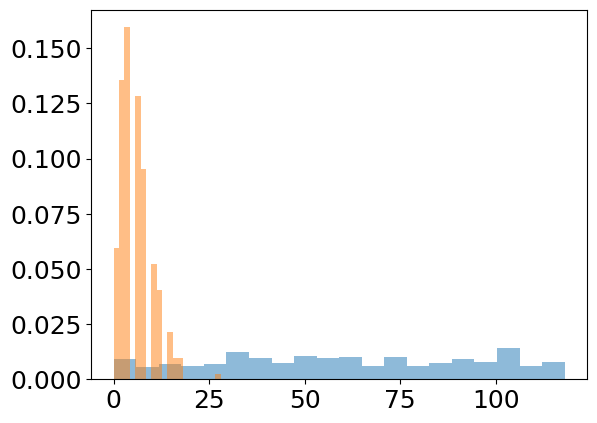

In [86]:
subkeys = np.asarray(jax.random.split(key, 300))

mcost = _final_cost_distribution(model, istate, subkeys, N_ADD)
ocost = _final_cost_distribution(opt_results.model, istate, subkeys, N_ADD)

plt.hist(mcost, bins=20, alpha=.5, density=True)
plt.hist(ocost, bins=20, alpha=.5, density=True);

### Initial Random Parameters

In [87]:
key, subkey = jax.random.split(key)
ss, _ = jxm.simulate(model, istate, subkey, N_ADD)

print(ss.celltype.sum(0) @ np.asarray([1.,-1.]))

24.0


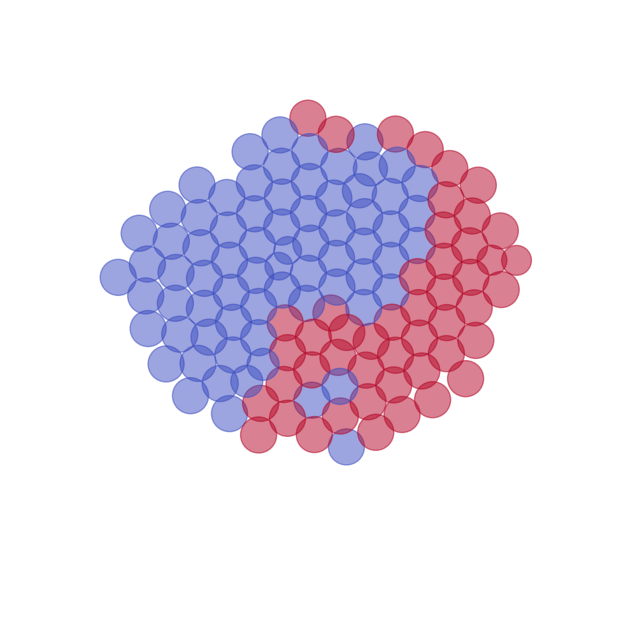

In [88]:
draw_circles_ctype(ss);

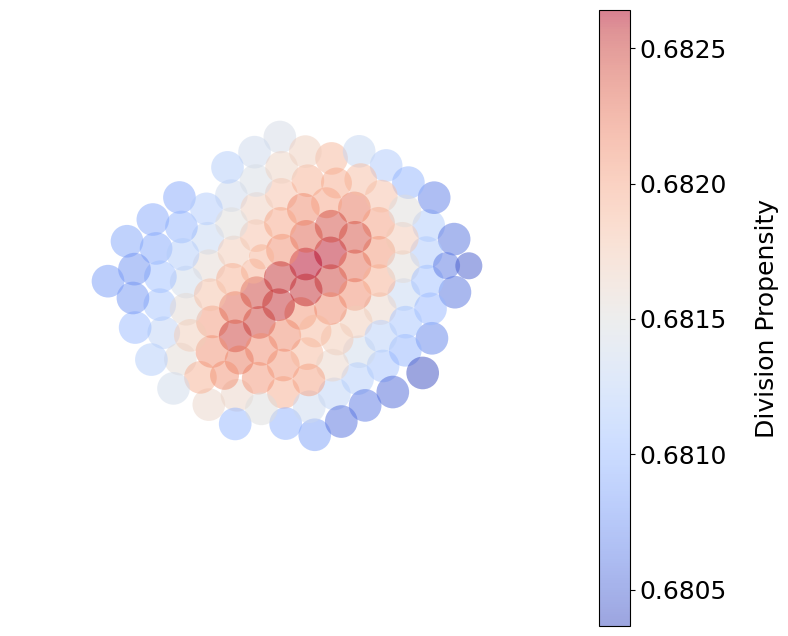

In [89]:
draw_circles_divrate(ss);

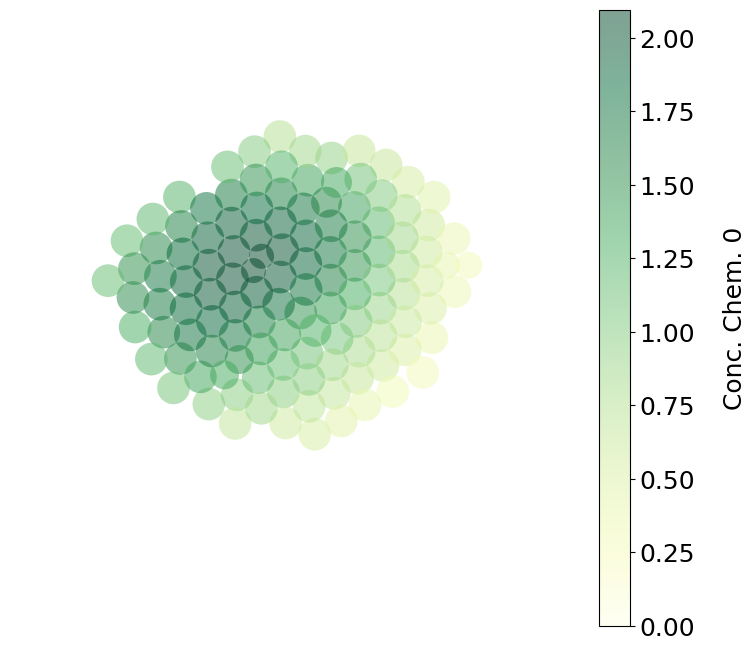

In [90]:
draw_circles_chem(ss, 0);

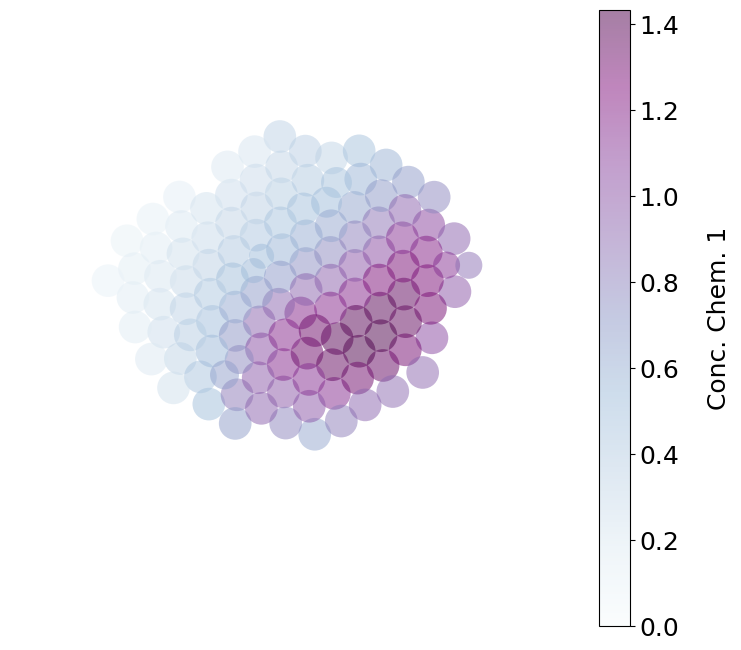

In [91]:
draw_circles_chem(ss, 1);

### Optimized Parameters

In [92]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_results.model, istate, subkey, N_ADD)

print(s.celltype.sum(0) @ np.asarray([1.,-1.]))

-4.0


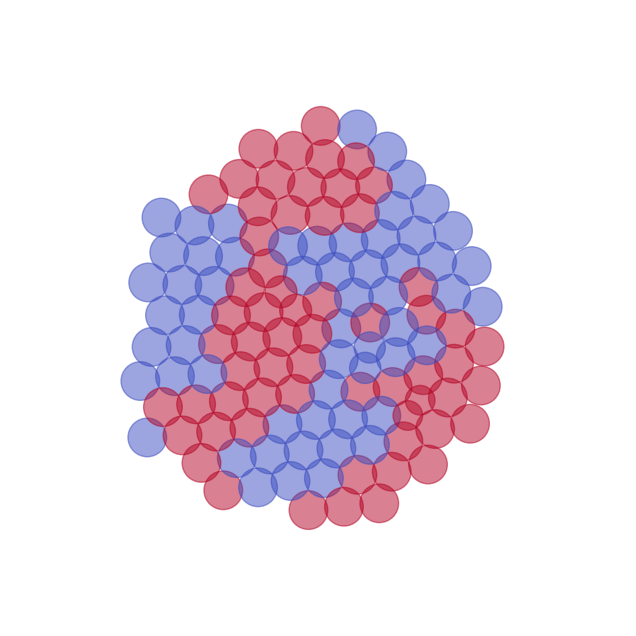

In [93]:
draw_circles_ctype(s);

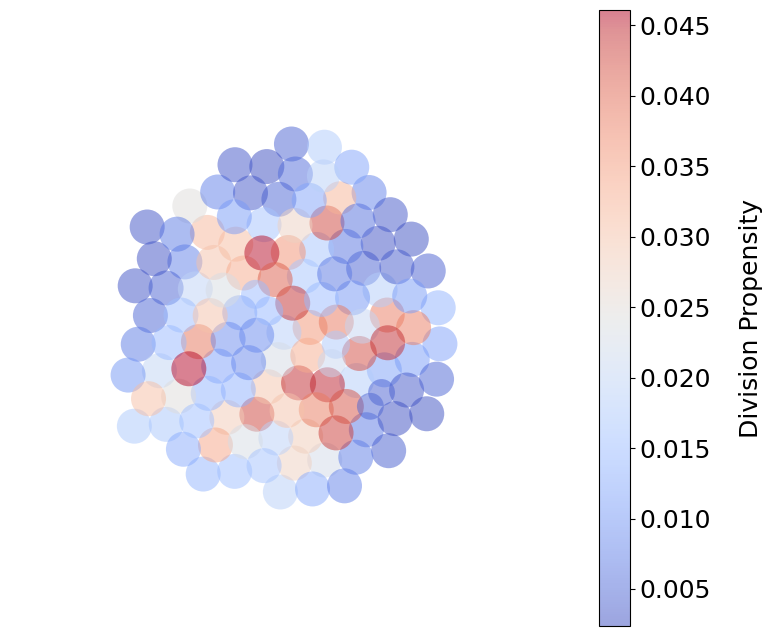

In [94]:
draw_circles_divrate(s);

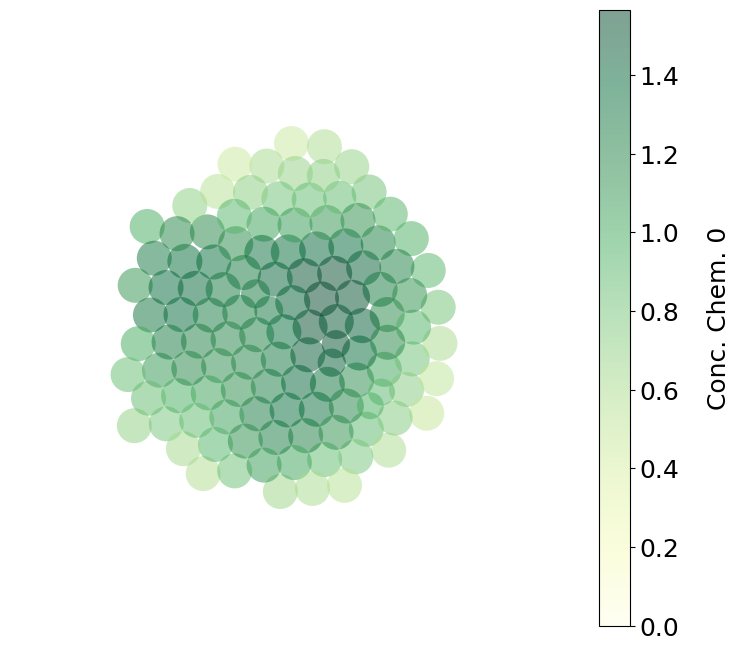

In [95]:
draw_circles_chem(s, 0);

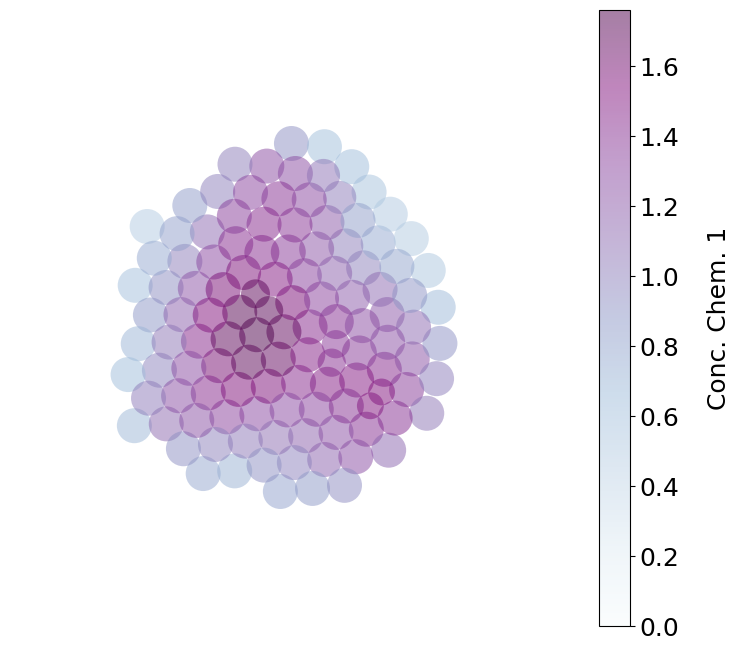

In [96]:
draw_circles_chem(s, 1);

## GeneNetwork Model

In [5]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.),
        # jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),

        jxm.cell.gene_networks.GeneNetwork(istate,
                            input_fields=['chemical', 'division', 'radius'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=.8,
                            ),

        jxm.cell.SecretionMaskByCellType(istate, np.eye(N_CTYPES).tolist()),
    ])


# POSSIBLE REASONS FOR NOT WORKING IN GENERAL:
# - sigmoids in the gene network
# - too small number of params in the gene network
# - gradient problems in the gene network (possibly connected to the sigmoids)

In [6]:
EPOCHS = 100
N_EPISODES = 8
N_VAL_EPISODES = 16

COST_FN = jxm.opt.cost_functions.CellTypeImbalance(metric='number')

GAMMA = .9
LAMBDA = 20.

LOSS = jxm.opt.losses.ReinforceLoss(COST_FN,
                                    n_sim_steps=N_ADD,
                                    n_episodes=N_EPISODES,
                                    n_val_episodes=N_VAL_EPISODES,
                                    gamma=GAMMA,
                                    lambda_l1=LAMBDA,
                                    )


opt_results = jxm.opt.train(model, istate, LOSS, key=key, epochs=EPOCHS)

Loss: 27.12500: 100%|█████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


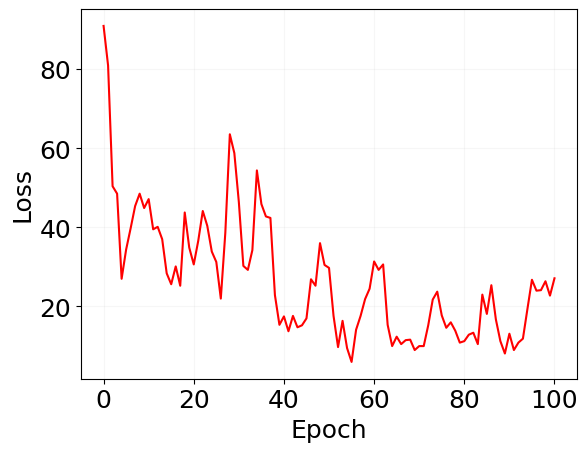

In [7]:
plt.plot(opt_results.loss_aux, 'r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.1);

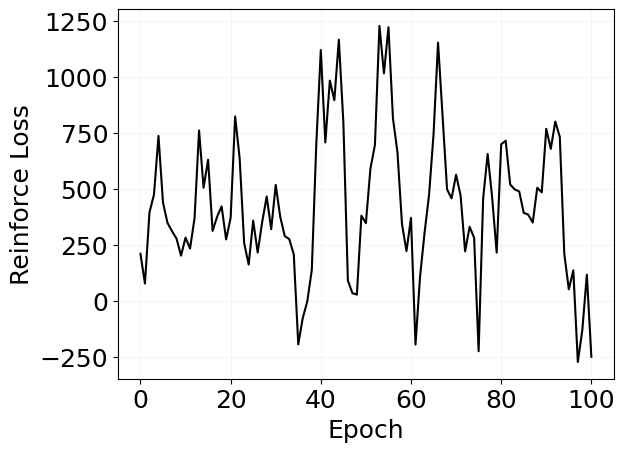

In [8]:
plt.plot(opt_results.loss, 'k')

plt.xlabel('Epoch')
plt.ylabel('Reinforce Loss')

plt.grid(alpha=.1);

In [9]:
def _final_cost_distribution(model, istate, subkeys, n_sim_steps):

    vsim = jax.vmap(jxm.simulate, (None, None, 0, None))

    fstate, _ = vsim(model, istate, subkeys, n_sim_steps)

    cost = fstate.celltype.sum(-2) @ np.asarray([1.,-1.])

    cost = np.abs(cost)

    return cost.tolist()

100%|███████████████████████████████████████████| 30/30 [00:31<00:00,  1.05s/it]


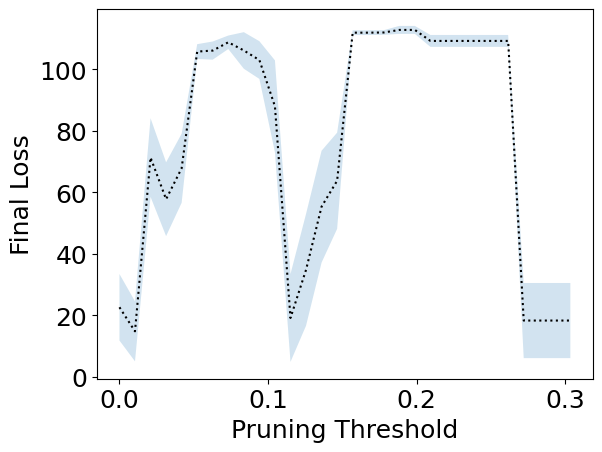

In [10]:
interact_mat = opt_results.model[-2].interaction_matrix

thrs = np.linspace(0., np.abs(interact_mat).max(), 30)

subkeys = np.asarray(jax.random.split(key, 100))

cc = []
for thr in tqdm(thrs):
    pm = eqx.tree_at(lambda m: m[-2].interaction_matrix, opt_results.model, np.where(np.abs(interact_mat)<thr, 0., interact_mat))
    cc += [_final_cost_distribution(pm, istate, subkeys, N_ADD)]


plt.plot(thrs, np.asarray(cc).mean(-1).tolist(), 'k:')
plt.fill_between(thrs, (np.asarray(cc).mean(-1) - np.asarray(cc).std(-1)).tolist(), (np.asarray(cc).mean(-1) + np.asarray(cc).std(-1)).tolist(), alpha=.2)

plt.xlabel('Pruning Threshold')
plt.ylabel('Final Loss');

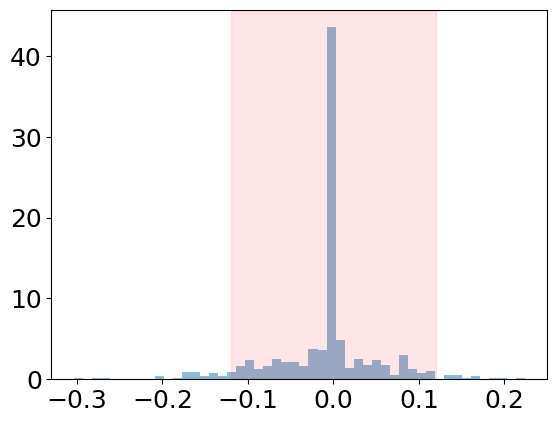

In [34]:
prune_thr = .12

plt.hist(opt_results.model[-2].interaction_matrix.flatten().tolist(), bins=50, alpha=.5, density=True)

plt.axvspan(-prune_thr, prune_thr, color='r', alpha=.1);

In [35]:
pruned_model = eqx.tree_at(lambda m: m[-2].interaction_matrix, opt_results.model, np.where(np.abs(opt_results.model[-2].interaction_matrix)>prune_thr, opt_results.model[-2].interaction_matrix, 0.))

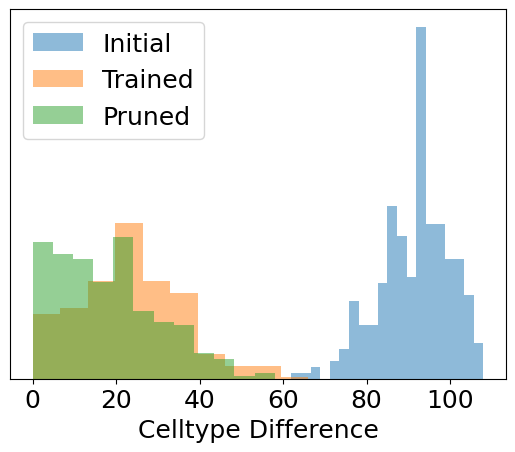

In [36]:
subkeys = np.asarray(jax.random.split(key, 300))

mcost = _final_cost_distribution(model, istate, subkeys, N_ADD)
ocost = _final_cost_distribution(opt_results.model, istate, subkeys, N_ADD)
pcost = _final_cost_distribution(pruned_model, istate, subkeys, N_ADD)

plt.hist(mcost, bins=20, alpha=.5, density=True, label='Initial')
plt.hist(ocost, bins=10, alpha=.5, density=True, label='Trained')
plt.hist(pcost, bins=12, alpha=.5, density=True, label='Pruned')

plt.xlabel('Celltype Difference')

plt.yticks([])

plt.legend();

In [37]:
np.where(np.abs(opt_results.model[-2].interaction_matrix)>prune_thr, 1., 0.).sum()

Array(40., dtype=float64)

### Initial Random Parameters

In [81]:
key, subkey = jax.random.split(key)
ss, _ = jxm.simulate(model, istate, subkey, N_ADD)

print(ss.celltype.sum(0) @ np.asarray([1.,-1.]))

-114.0


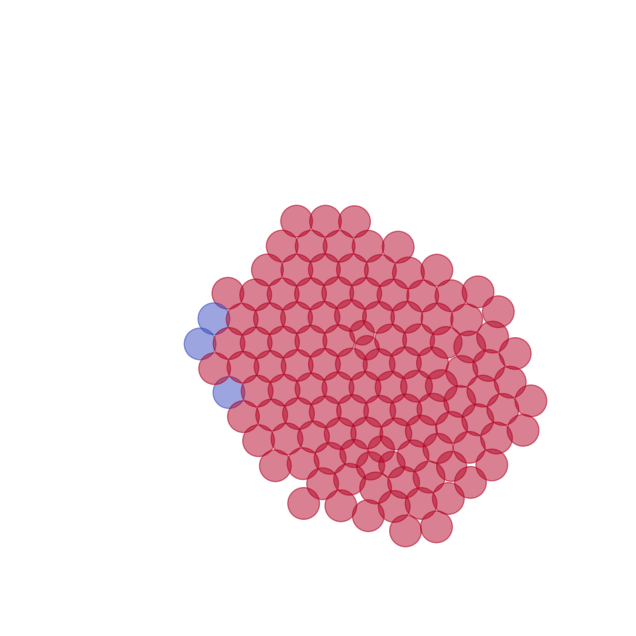

In [82]:
draw_circles_ctype(ss);

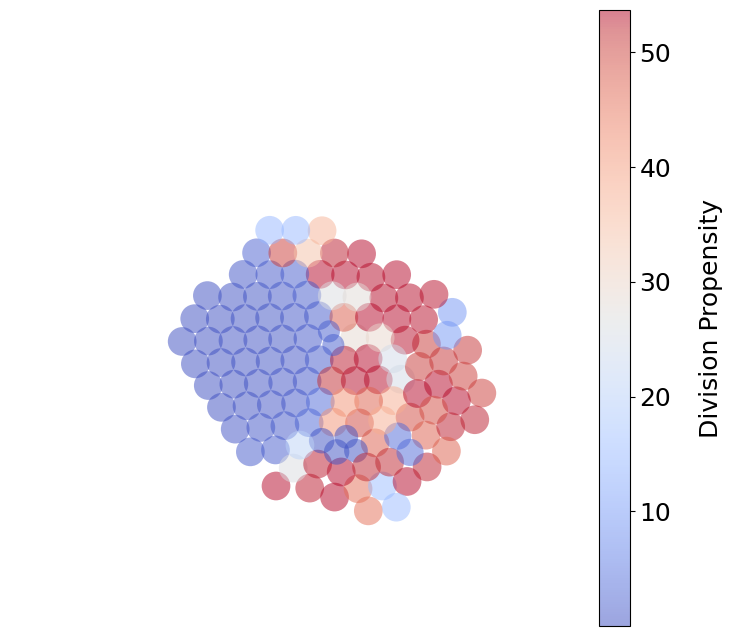

In [83]:
draw_circles_divrate(ss);

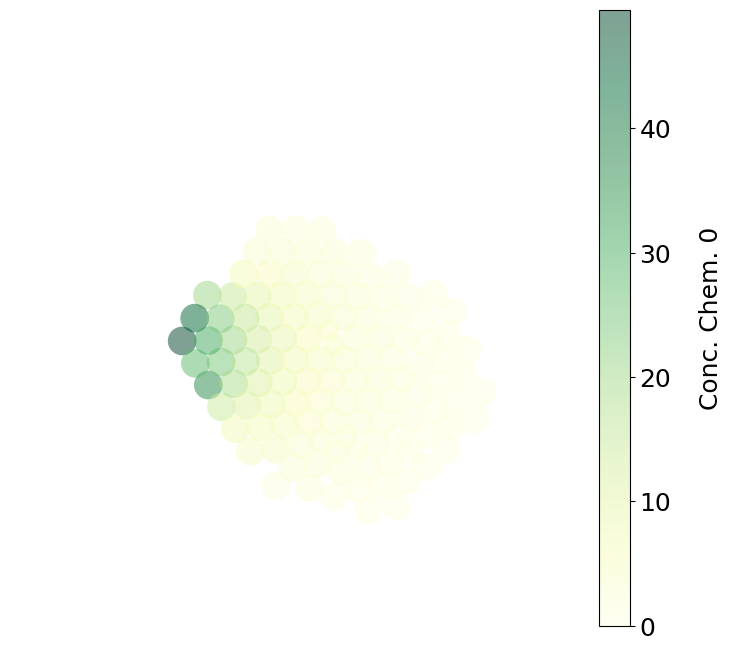

In [84]:
draw_circles_chem(ss, 0);

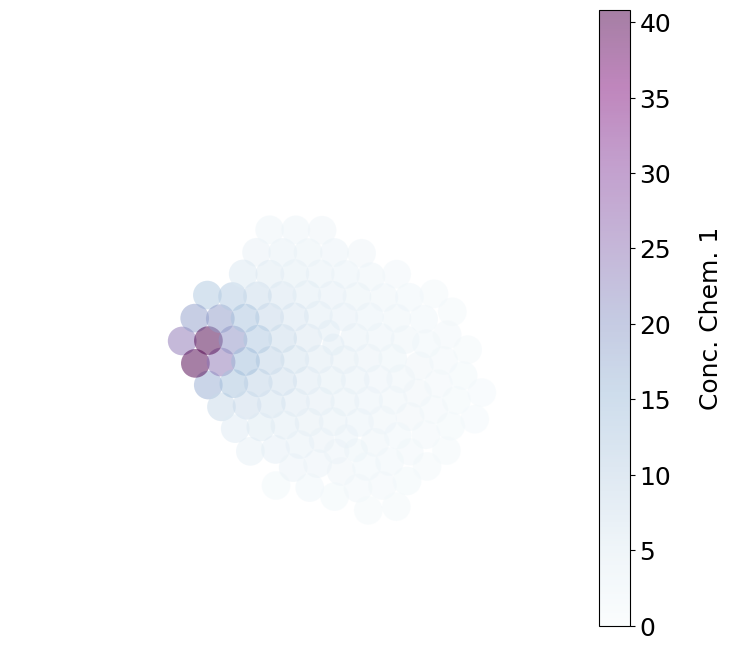

In [85]:
draw_circles_chem(ss, 1);

### Optimized Parameters

In [39]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_results.model, istate, subkey, N_ADD)

print(s.celltype.sum(0) @ np.asarray([1.,-1.]))

0.0


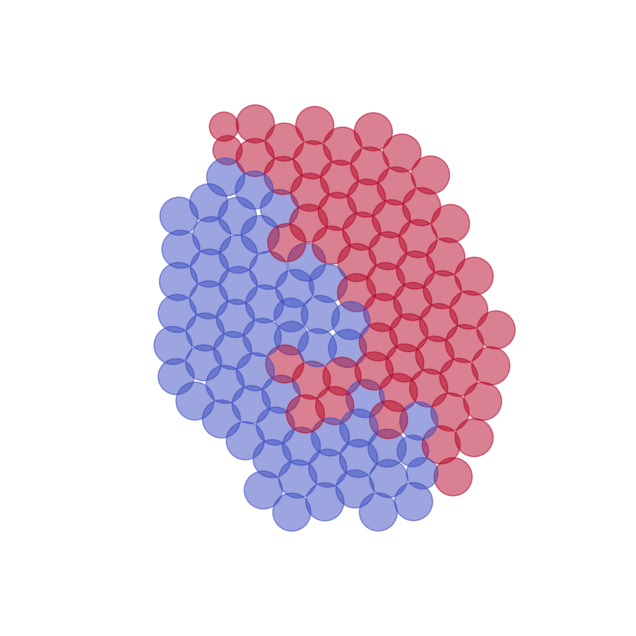

In [40]:
draw_circles_ctype(s);

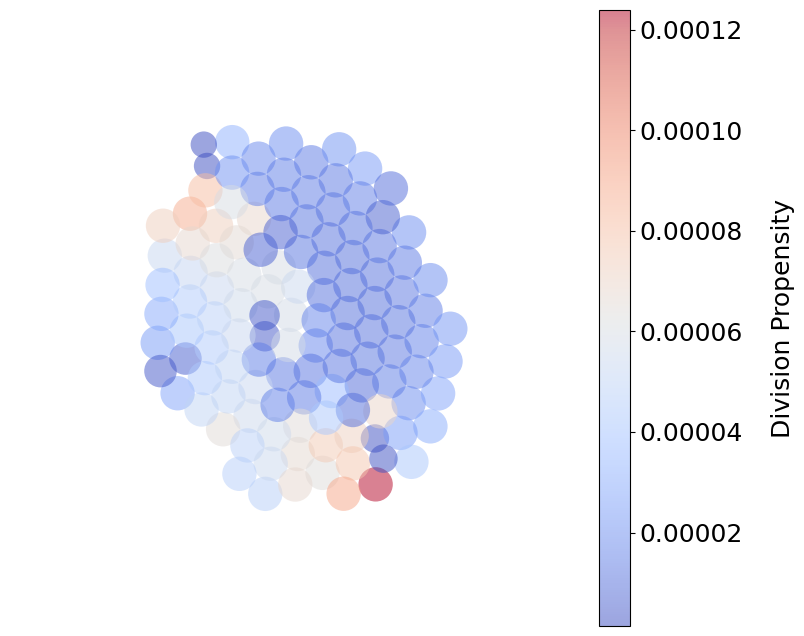

In [41]:
draw_circles_divrate(s);

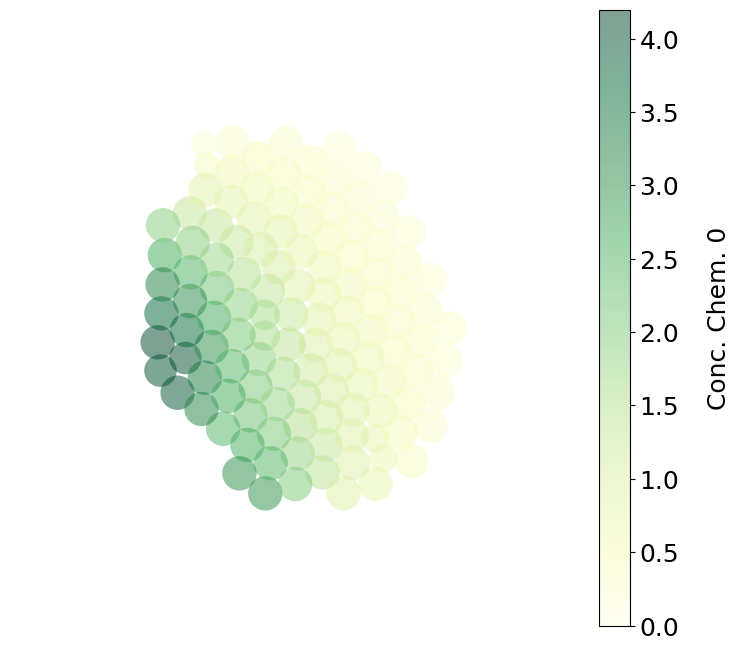

In [42]:
draw_circles_chem(s, 0);

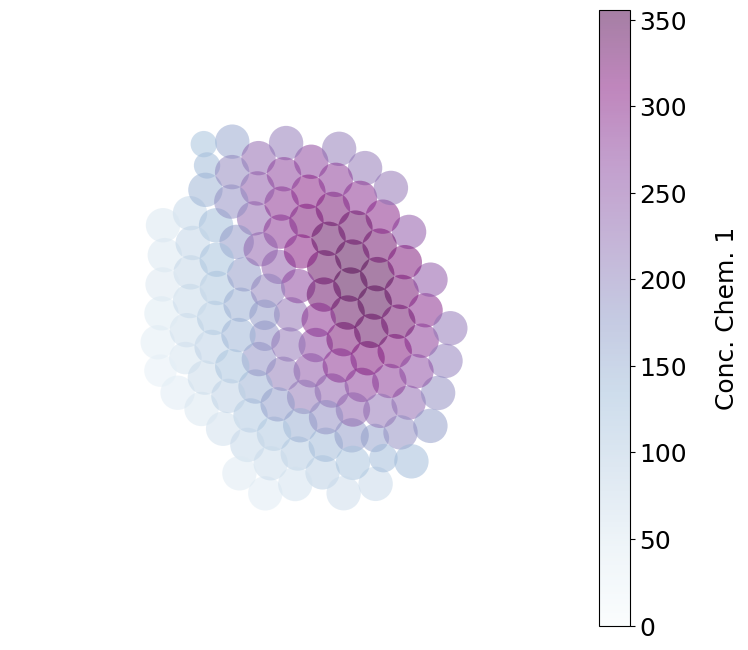

In [43]:
draw_circles_chem(s, 1);

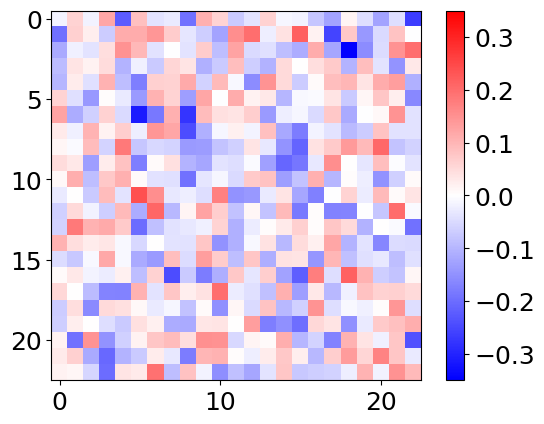

In [24]:
plt.imshow(model[-2].interaction_matrix, cmap='bwr', vmin=-.35, vmax=.35)
plt.colorbar();

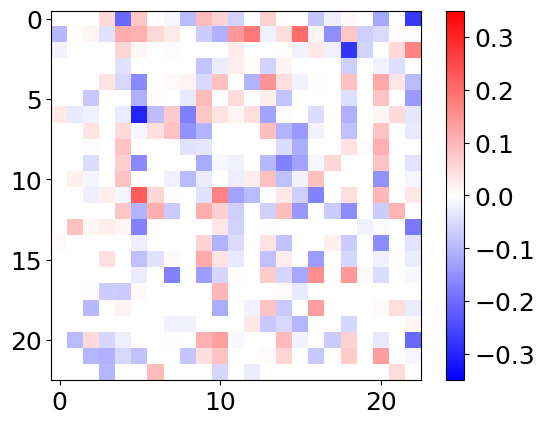

In [44]:
plt.imshow(opt_results.model[-2].interaction_matrix, cmap='bwr', vmin=-.35, vmax=.35)
plt.colorbar();

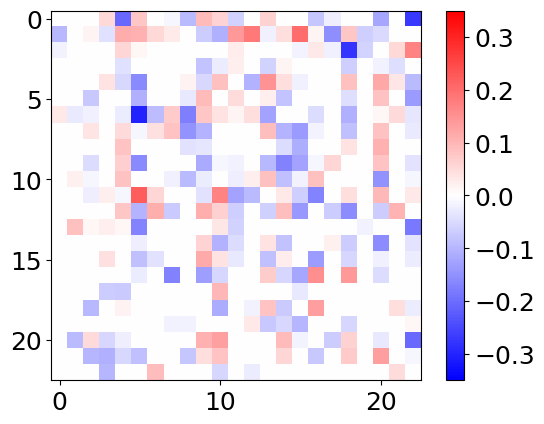

In [26]:
plt.imshow(pruned_model[-2].interaction_matrix, cmap='bwr', vmin=-.35, vmax=.35)
plt.colorbar();

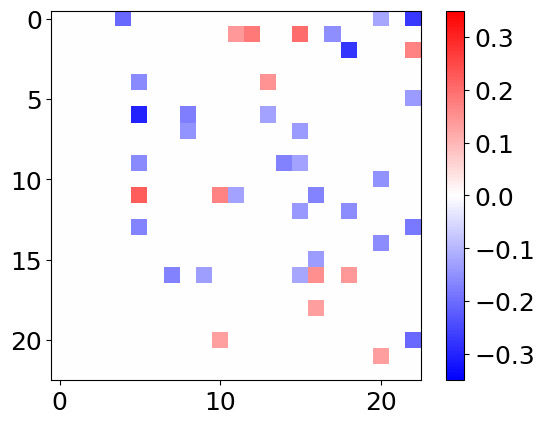

In [38]:
plt.imshow(pruned_model[-2].interaction_matrix, cmap='bwr', vmin=-.35, vmax=.35)
plt.colorbar();